In [5]:
import torch, torchvision
model = torchvision.models.resnet18(pretrained=True)
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

In [12]:
import torch,torchvision

a = torch.tensor([2.,3.],requires_grad=True)
b = torch.tensor([4.,6.],requires_grad=True)
Q = 3*a**3 - b**2

上面两种定义方式得到CNN功能都是相同的，至于喜欢哪一种方式，是个人口味问题，
但PyTorch官方推荐：具有学习参数的（例如，conv2d, linear, batch_norm)
采用nn.Xxx方式，没有学习参数的（例如，maxpool, loss func, activation func）
等根据个人选择使用nn.functional.xxx或者nn.Xxx方式。
但关于dropout，个人强烈推荐使用nn.Xxx方式，因为一般情况下只有训练阶段才进行dropout
，在eval阶段都不会进行dropout。
使用nn.Xxx方式定义dropout，在调用model.eval()之后，
model中所有的dropout layer都关闭，但以nn.function.dropout方式定义dropout，
在调用model.eval()之后并不能关闭dropout。

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        #1 input image channel, 6 output channels,3×3 square
        self.conv1 = nn.Conv2d(1,6,3)
        self.conv2 = nn.Conv2d(6,16,3)
        
        self.fc1 = nn.Linear(16*6*6,120) #6*6 from image dimension
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,x):
        #Max pooling over a (2,2) window
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self,x):
        size = x.size()[1:]

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


In [8]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0425,  0.0023, -0.0823,  0.1116,  0.1341, -0.0616, -0.1168,  0.0779,
          0.0668,  0.0236]], grad_fn=<AddmmBackward>)


In [9]:
net.zero_grad()
out.backward(torch.randn(1, 10))

In [10]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.2547, grad_fn=<MseLossBackward>)


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


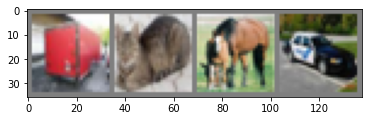

truck   cat horse   car


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.258
[1,  4000] loss: 1.932
[1,  6000] loss: 1.678
[1,  8000] loss: 1.588
[1, 10000] loss: 1.504
[1, 12000] loss: 1.457
[2,  2000] loss: 1.380
[2,  4000] loss: 1.355
[2,  6000] loss: 1.329
[2,  8000] loss: 1.312
[2, 10000] loss: 1.294
[2, 12000] loss: 1.261
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

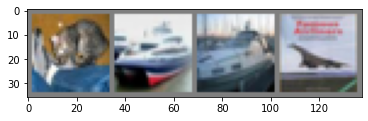

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
outputs = net(images)


In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship plane plane


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [24]:
class_correct = list(0\. for i in range(10))
class_total = list(0\. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

SyntaxError: unexpected character after line continuation character (<ipython-input-24-6f7571952991>, line 1)